# How does Dominoes work? - A supervised learning approach to learn game dynamics and rewards from one-hot-encoded game states and actions.

## I. The Problem
### I.I. The Learning Problem
To learn the game dynamics, we have the model predict the next state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) based on the previous state (length 30 one-hot-encoded vector) and an action (length 21 one-hot-encoded vector).  
### I.II. The Input Data
The input data consists of the current state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) and an action (length 21 one-hot-encoded vector). We use it to predict either the next state (length 30 one-hot-encoded vector) or the probability that a given action in this situation leads to success.  
Since the data used for training is collected from multiple games, it needs to be cleaned so that it is not the case that for the same combination of state and action, multiple probabilities can be learned.

In [1]:
import warnings  
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import keras.backend as K
    import tensorflow as tf
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.models import Sequential, Model, clone_model

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from itertools import product

Using TensorFlow backend.


In [2]:
#check if GPU is available for calculations
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
"""
reads in training data from file and divides it into input state, next state and probability of winning
outputs a dictionary with training and testing data
"""

def divide_train_data(training_path, clean = False, test_size = 0.2):
    pandas_train = pd.read_csv(training_path,sep=';')
    if clean:
        pandas_train = clean_data(pandas_train)
    pandas_train = pandas_train.sample(frac=1).reset_index(drop=True)
    train, test = train_test_split(pandas_train,test_size = test_size)
    train_inputs = train.iloc[:,0:51]
    train_next_label = train.iloc[:,51:81]
    train_pred_label = train.iloc[:,-2:-1]
    test_inputs = test.iloc[:,0:51]
    test_next_label = test.iloc[:,51:81]
    test_pred_label = test.iloc[:,-2:-1]
    train_dict = {"input": train_inputs.to_numpy(), "next":train_next_label.to_numpy(), "pred": train_pred_label.to_numpy()}
    test_dict = {"input": test_inputs.to_numpy(), "next": test_next_label.to_numpy(), "pred": test_pred_label.to_numpy()}
    return train_dict, test_dict

"""
removes duplicate instances of the same state-input-state sequences keeping only the most-visited states
"""
def clean_data(dataframe):
    cleaned_df = dataframe
    cleaned_df_str = convert_cols(cleaned_df, str)
    cleaned_df_str['combo'] = cleaned_df_str.apply(lambda x: ''.join(x), axis=1)
    cleaned_df_str['combo'] = cleaned_df_str['combo'].str[:51]
    cleaned_df_str = cleaned_df_str.sort_values('n', ascending=False).drop_duplicates(['combo'])
    cleaned_df_str = cleaned_df_str.drop('combo', 1)
    cleaned_df = convert_cols(cleaned_df_str, float)
    diff = dataframe.shape[0] - cleaned_df.shape[0]
    print("Removed {} duplicates with different probability scores".format(diff))
    print("This leaves {} instances for training and testing".format(cleaned_df.shape[0]))
    return cleaned_df

"""
converts columns (optinally specified by indices) in a dataframe into the specified data type
"""
def convert_cols(dataframe, datatype, indices=None):
    res_df = dataframe
    if indices:
        for col in list(res_df.columns.values)[indices]:
            res_df[col] = res_df[col].astype(datatype)
    else:
        for col in list(res_df.columns.values):
            res_df[col] = res_df[col].astype(datatype)
    return res_df

## II. The Solution

In [4]:
"""
draws accuracy and loss curves for training
"""
def show_acc_loss_curves(hist, metric = "acc"):
    if metric == "mea":
        draw_dict = {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}}
    elif metric == "acc":
        draw_dict = {"loss": {"full": "loss"}, "acc": {"full": "accuracy"}}
    elif metric == "both":
        {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}, "acc": {"full": "accuracy"}}
        
    fig, axes = plt.subplots(nrows=1, ncols=len(draw_dict.keys()), figsize=(15, 5))

    
    for i, key in enumerate(draw_dict.keys()):
        axes[i].plot(hist.history[key])
        axes[i].plot(hist.history['val_'+key])
        axes[i].set_title('model '+draw_dict[key]["full"])
        axes[i].set_ylabel(key)
        axes[i].set_xlabel('epoch')
        axes[i].legend(['train', 'test'], loc='upper left')
    fig.tight_layout()

"""
evaluates model for either next state (test="next") or probablity of winning (test="pred") and return evaluation metrics
"""
def test_model(model, test_data, test):
    return model.evaluate(test_data["input"], test_data[test], verbose=0)

### II.I. Supervised Learning of Game Dynamics
To learn the game dynamics, we have the model predict the next state based on the previous state and an action.  
To do this, we use a simple neural network with a ```51-120-30``` structure.

In [5]:
dyn_model = Sequential()
dyn_model.add(Dense(120,input_dim=51, activation="relu"))
dyn_model.add(Dense(30, activation='sigmoid'))
dyn_model.compile(loss='binary_crossentropy',
              optimizer='adam', # Root Mean Square Propagation
              metrics=['acc']) # Accuracy performance metric
dyn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               6240      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3630      
Total params: 9,870
Trainable params: 9,870
Non-trainable params: 0
_________________________________________________________________


#### Data Processing
We then read in the entire training data and divide it into a training and testing data set (20% of data being used for testing).

In [6]:
train_data, test_data = divide_train_data("train-200games-1000-iter.csv", clean=True)

Removed 5849 duplicates with different probability scores
This leaves 7585 instances for training and testing


#### Training
We subsequently train the model to predict the next state from the current state and a given action.

In [7]:
dyn_history = dyn_model.fit(train_data["input"], train_data["next"], epochs=500, batch_size=50, verbose=0, 
                        validation_split=0.33)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Results  
The results show that the network is able to quickly extract the relevant dynamics from the input data, represented by the steep decline of the loss curve after only a few epochs.

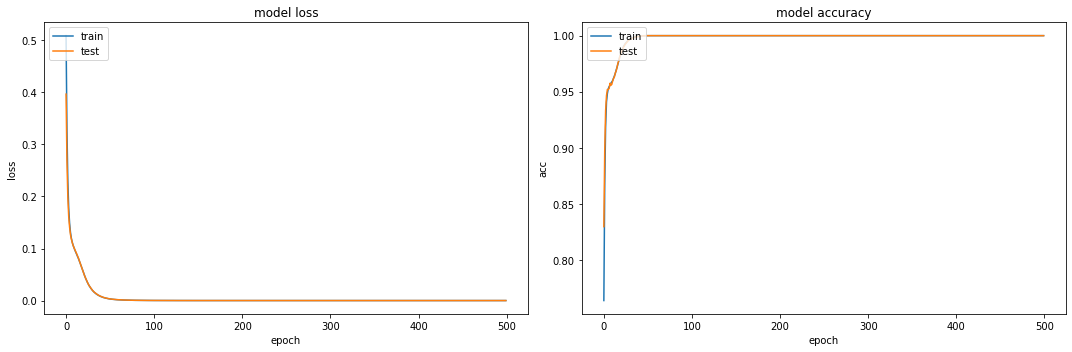

In [8]:
# summarize history for loss and acc
show_acc_loss_curves(dyn_history)

In [9]:
results = test_model(dyn_model, test_data, test="next")
print("loss: {}, acc: {}".format(results[0],results[1]))

loss: 8.044208172643254e-09, acc: 1.0


### II.II. Transfer Learning
In order to better learn the probability that a given action in a specific situation leads to winning the game, we use the trained model from the previous task and attach 2 more layers on top of it. This is meant to use the knowledge gained about game dynamics for predicting the probability of winning after a given action.  

#### Distribution of labels
First however, we take a look at the distribution of outcome probabilities.  
As we can see, they are not equally distributed, which makes sense as most actions have a low probability of success. Two other peaks occur for ambigous actions (p~0.5) and actions with a high probability of winning.

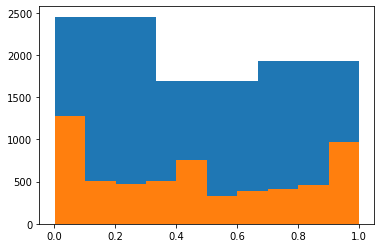

In [10]:
plt.hist(train_data["pred"],bins=3)
plt.hist(train_data["pred"])
plt.show()

In [11]:
# define custom log loss
def log_loss(y_true, y_pred):
    return K.mean(-K.log(abs(y_true - y_pred)))

# define custom mean absolute error metric
def mea_metric(y_true, y_pred):
    return K.mean(abs(y_true - y_pred))
"""
creates deep copy of a model including its weights
"""
def copy_model(model, loss, optimiser):
    model_copy= clone_model(model)
    
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)
        
    model_copy.compile(loss=loss, optimizer=opt, metrics=["acc", mea_metric])
    model_copy.set_weights(model.get_weights())
    return model_copy

"""
creates model based on given input parameters
"""
def create_model(last_activation, loss_funct, optimiser, learning_rate, base_model = dyn_model, transfer_learning = True):
    # remove output layer of base model
    if loss_funct == "log_loss":
        loss_funct = log_loss

    # transfer learning condition
    if transfer_learning:
        model = copy_model(base_model, loss_funct, optimiser)
        model.pop()
        model.layers[0].trainable = False
        # additional layers for learning
        start = Dense(120, activation='relu')(model.layers[-1].output)
        end = Dense(250, activation='relu')(start)
        out_r = Dense(1, activation=last_activation, name='r_prop')(end)
        final_model = Model(model.input,out_r)
    else:
        final_model = Sequential()
        final_model.add(Dense(120,input_dim=51, activation="relu"))
        final_model.add(Dense(250, activation='relu'))
        final_model.add(Dense(1, activation=last_activation, name='r_prop'))
        
    # Compile model
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)
    final_model.compile(loss=loss_funct, optimizer=opt, metrics=["acc", mea_metric])
    
    return final_model

#### Grid Search
Since we were not completely sure which combination of activation and loss functions was best suited to this purpose, we created a grid search over the following parameters:  
- ***activation of last layer***: sigmoid or linear
- ***loss function***: cross-entropy/logloss, mean squared error/Brier score for logistic activation
- ***optimiser***: Nesterov Momentum (NAG), Adaptive Moment Estimation (ADAM)
- ***learning rate***: 0.0001, 0.001, 0.01, 0.1
- ***batch size***: 10, 50, 100, 500  
  

Since two different loss functions will be tested, comparing the loss will not be sufficient. Thus, as an independent metric, we addtionally measure the ***mean absolute error*** (mae) when evaluating the model.

In [ ]:
# set hyperparameter search space
last_activation = ["linear", "sigmoid"]
loss_funct = ["mse"]
optimiser = ["nag", "adam"]
learning_rate = [0.0001, 0.001]
batch_size = [10, 50, 100, 500]
epochs = [100]
transfer = [True]

# create list of all different parameter combinations
param_grid = dict(last_activation = last_activation, loss_funct = loss_funct, optimiser = optimiser,
                  learning_rate = learning_rate, batch_size = batch_size, epochs = epochs, transfer = transfer)
combinations = list(product(*param_grid.values()))


# create containers for resulting data
res_df = pd.DataFrame(columns=['transfer','last activation','loss_funct','optimiser','learning rate','batch size',
                               'loss1', 'acc1', 'mae1',
                               'loss2', 'acc2', 'mae2',
                               'loss3', 'acc3', 'mae3'])
hist_dict_global = {}


# 3-fold grid search over the combinations defined above
for i, combination in enumerate(combinations):
    
    kf = KFold(n_splits=3, random_state=42, shuffle=False)
    hist_dict_local = {}
    metrics_dict = {}
    
    print("{}/{}: {} - folds completed: ".format(i+1,len(combinations), combination), end="", flush=True)
    
    for j, (train_index, test_index) in enumerate(kf.split(train_data["input"])):
        X_train, X_test = train_data["input"][train_index], train_data["input"][test_index]
        y_train, y_test = train_data["pred"][train_index], train_data["pred"][test_index]
        
        try:
            model = create_model(combination[0], combination[1], combination[2], combination[3], 
                                 transfer_learning = combination[6])
            hist = model.fit(X_train, y_train, epochs=combination[5], batch_size=combination[4], verbose=0, 
                             validation_data=(X_test, y_test), use_multiprocessing = True)
            hist_dict_local[j+1] = hist
        except Exception as error:
            hist_dict_local[j+1] = None
            print("Training failed for {} - fold {}".format(combination, j+1))
            traceback.print_exc()
        
        try:        
            loss, acc, mae = test_model(model, test_data, test="pred")
            metrics_dict[j+1] = {"loss": loss, "acc": acc, "mae": mae}
            
            if j < 2:
                print("{}-".format(j+1), end="", flush=True)
            else:
                print("{}".format(j+1))
            
        except Exception as error:
            hist_dict_local[j+1] = None
            metrics_dict[j+1] = {"loss": None, "mae": None}
            print("Metric calculations failed for {} - fold {}".format(combination, j+1))
            traceback.print_exc()
    
    row = {'transfer': combination[6], 'last activation': combination[0],'loss_funct': combination[1],
           'optimiser': combination[2], 'learning rate': combination[3], 'batch size': combination[4],
           'loss1': metrics_dict[1]["loss"], 'acc1': metrics_dict[1]["acc"], 'mae1': metrics_dict[1]["mae"],
           'loss2': metrics_dict[2]["loss"], 'acc2': metrics_dict[2]["acc"], 'mae2': metrics_dict[2]["mae"],
           'loss3': metrics_dict[3]["loss"], 'acc3': metrics_dict[3]["acc"], 'mae3': metrics_dict[3]["mae"]}
    res_df = res_df.append(row , ignore_index=True)
    res_df.to_csv("grid_search_data.csv" , sep=";")
    hist_dict_global[combination] = hist_dict_local
    

## III. Analysis
The first grid search consisted of 128 different combinations with 3 results for loss, accuracy and mae.  

In [12]:
# read in data
data = pd.read_csv("grid_search_data.csv", sep=";", index_col=0)

### III.I. NaN-Removal
Unfortunately, due to unlucky combinations of learning rate and loss function, some of the results are represented as ```NaN``` values.

In [13]:
null_columns=data.columns[data.isnull().any()]
idx = data.index[data.isnull().any(1)]
print("Out of {} results, {} contain NaNs.".format(data.shape[0], data.loc[idx,:].shape[0]))
print("The columsn including NaNs are {}".format(list(null_columns)))

Out of 128 results, 33 contain NaNs.
The columsn including NaNs are ['loss1', 'mae1', 'loss2', 'mae2', 'loss3', 'mae3']


So, as there are NaNs for loss and mae values, for each combination, we count the number of NaNs, as meaningful aggregation metrics (like mean and standard deviation) can only be computed based on a minimum of two values.  
Since only the mean absolute error can be meaningfully compared, we limit our analysis to the mae metrics.

In [14]:
# check for nan values in mae columns
data["mae_na"] = data.loc[:,["mae1","mae2", "mae3"]].isnull().sum(1)
# and see how they are distributed over different combinations
data.groupby(["last activation", "loss_funct", "optimiser"])["mae_na"].value_counts()

last activation  loss_funct  optimiser  mae_na
linear           log_loss    adam       0         16
                             nag        0         16
                 mse         adam       0         16
                             nag        0          8
                                        3          6
                                        2          2
sigmoid          log_loss    adam       2          9
                                        1          4
                                        0          3
                             nag        1          7
                                        0          4
                                        2          4
                                        3          1
                 mse         adam       0         16
                             nag        0         16
Name: mae_na, dtype: int64

We see, that most NaNs are created when combining a sigmoid activation function, with log-loss and adam-optimiser (13 cases of NaNs), followed by the combinations sigmoid-log_loss-nag (12) and linear-mse-nag (8).  
  
The next step is to remove all instances with 2 or more missing maes as otherwise no meaningful aggreagation metrics can be computed.

### III.II. Calculation and analysis of aggregation metrics (mea mean and std)
Afterwards we calculate mean and standard devaiation of the mea estimate and save the minimum value from all 3 folds also,

In [15]:
# remove rows that don't have a at least 2 mae scores
data_rm_na = data[(data.mae_na < 2)]
data_rm_na = data_rm_na.copy()

In [16]:
# compute aggregation metrics
data_rm_na["mae_mean"] = data_rm_na[['mae1', 'mae2', 'mae3']].mean(axis=1, skipna = True)
data_rm_na["mae_std"] = data_rm_na[['mae1', 'mae2', 'mae3']].std(axis=1, skipna = True)
# get minimum value
data_rm_na["mae_min"] = data_rm_na[["mae1","mae2", "mae3"]].min(1)

As we compare the top 5 results sorted by either ascending minimum mae or ascending mean mae, we see that the top 3 results are the same and that the best results are achieved with the mean squared error loss function and that the nag optimiser seems to also lead to better results in the majority of times.

In [17]:
col_list = ["last activation", "loss_funct", "optimiser", "learning rate", "batch size", "mae1", "mae2", "mae3", "mae_mean", "mae_std", "mae_min"]
data_rm_na.sort_values(axis=0, by="mae_min")[col_list].head(10)

,last activation,loss_funct,optimiser,learning rate,batch size,mae1,mae2,mae3,mae_mean,mae_std,mae_min
64,sigmoid,mse,nag,0.0001,10,0.236169,0.237950,0.235087,0.236402,0.001445,0.235087
70,sigmoid,mse,nag,0.0010,100,0.239391,0.236466,0.236841,0.237566,0.001592,0.236466
69,sigmoid,mse,nag,0.0010,50,0.240394,0.251649,0.244099,0.245381,0.005736,0.240394
3,sigmoid,mse,nag,0.0100,500,0.249529,0.262735,0.242378,0.251547,0.010328,0.242378
98,linear,mse,nag,0.0001,100,0.254174,0.247068,0.244842,0.248695,0.004874,0.244842
41,linear,mse,adam,0.0100,50,0.252557,0.245523,0.268267,0.255449,0.011645,0.245523
42,linear,mse,adam,0.0100,100,0.260853,0.246119,0.250726,0.252566,0.007537,0.246119
43,linear,mse,adam,0.0100,500,0.274805,0.263723,0.246428,0.261652,0.014301,0.246428
97,linear,mse,nag,0.0001,50,0.250003,0.254338,0.246466,0.250269,0.003943,0.246466
103,linear,mse,nag,0.0010,500,0.247662,0.254865,0.252870,0.251799,0.003719,0.247662


In [18]:
data_rm_na.sort_values(axis=0, by="mae_mean")[col_list].head(10)

,last activation,loss_funct,optimiser,learning rate,batch size,mae1,mae2,mae3,mae_mean,mae_std,mae_min
64,sigmoid,mse,nag,0.0001,10,0.236169,0.237950,0.235087,0.236402,0.001445,0.235087
70,sigmoid,mse,nag,0.0010,100,0.239391,0.236466,0.236841,0.237566,0.001592,0.236466
69,sigmoid,mse,nag,0.0010,50,0.240394,0.251649,0.244099,0.245381,0.005736,0.240394
98,linear,mse,nag,0.0001,100,0.254174,0.247068,0.244842,0.248695,0.004874,0.244842
97,linear,mse,nag,0.0001,50,0.250003,0.254338,0.246466,0.250269,0.003943,0.246466
71,sigmoid,mse,nag,0.0010,500,0.249200,0.252591,0.249421,0.250404,0.001897,0.249200
3,sigmoid,mse,nag,0.0100,500,0.249529,0.262735,0.242378,0.251547,0.010328,0.242378
103,linear,mse,nag,0.0010,500,0.247662,0.254865,0.252870,0.251799,0.003719,0.247662
42,linear,mse,adam,0.0100,100,0.260853,0.246119,0.250726,0.252566,0.007537,0.246119
110,linear,mse,adam,0.0010,100,0.254519,0.255883,0.252249,0.254217,0.001836,0.252249


To get a better overview of the different performance for the different combinations, we want to group the data by last activation, loss function and optimiser and average over all learning rates and batch sizes.  
However, to see if this is justified, we first have to take a look a the mae for batch sizes and learning rates in order to check if the mean accurately approximates the mae over all conditions. 

In [19]:
sns.set(style="ticks")
plt_data = data_rm_na.copy()
plt_data["combi"] = plt_data["last activation"] +"-"+ plt_data["loss_funct"] +"-"+ plt_data["optimiser"]

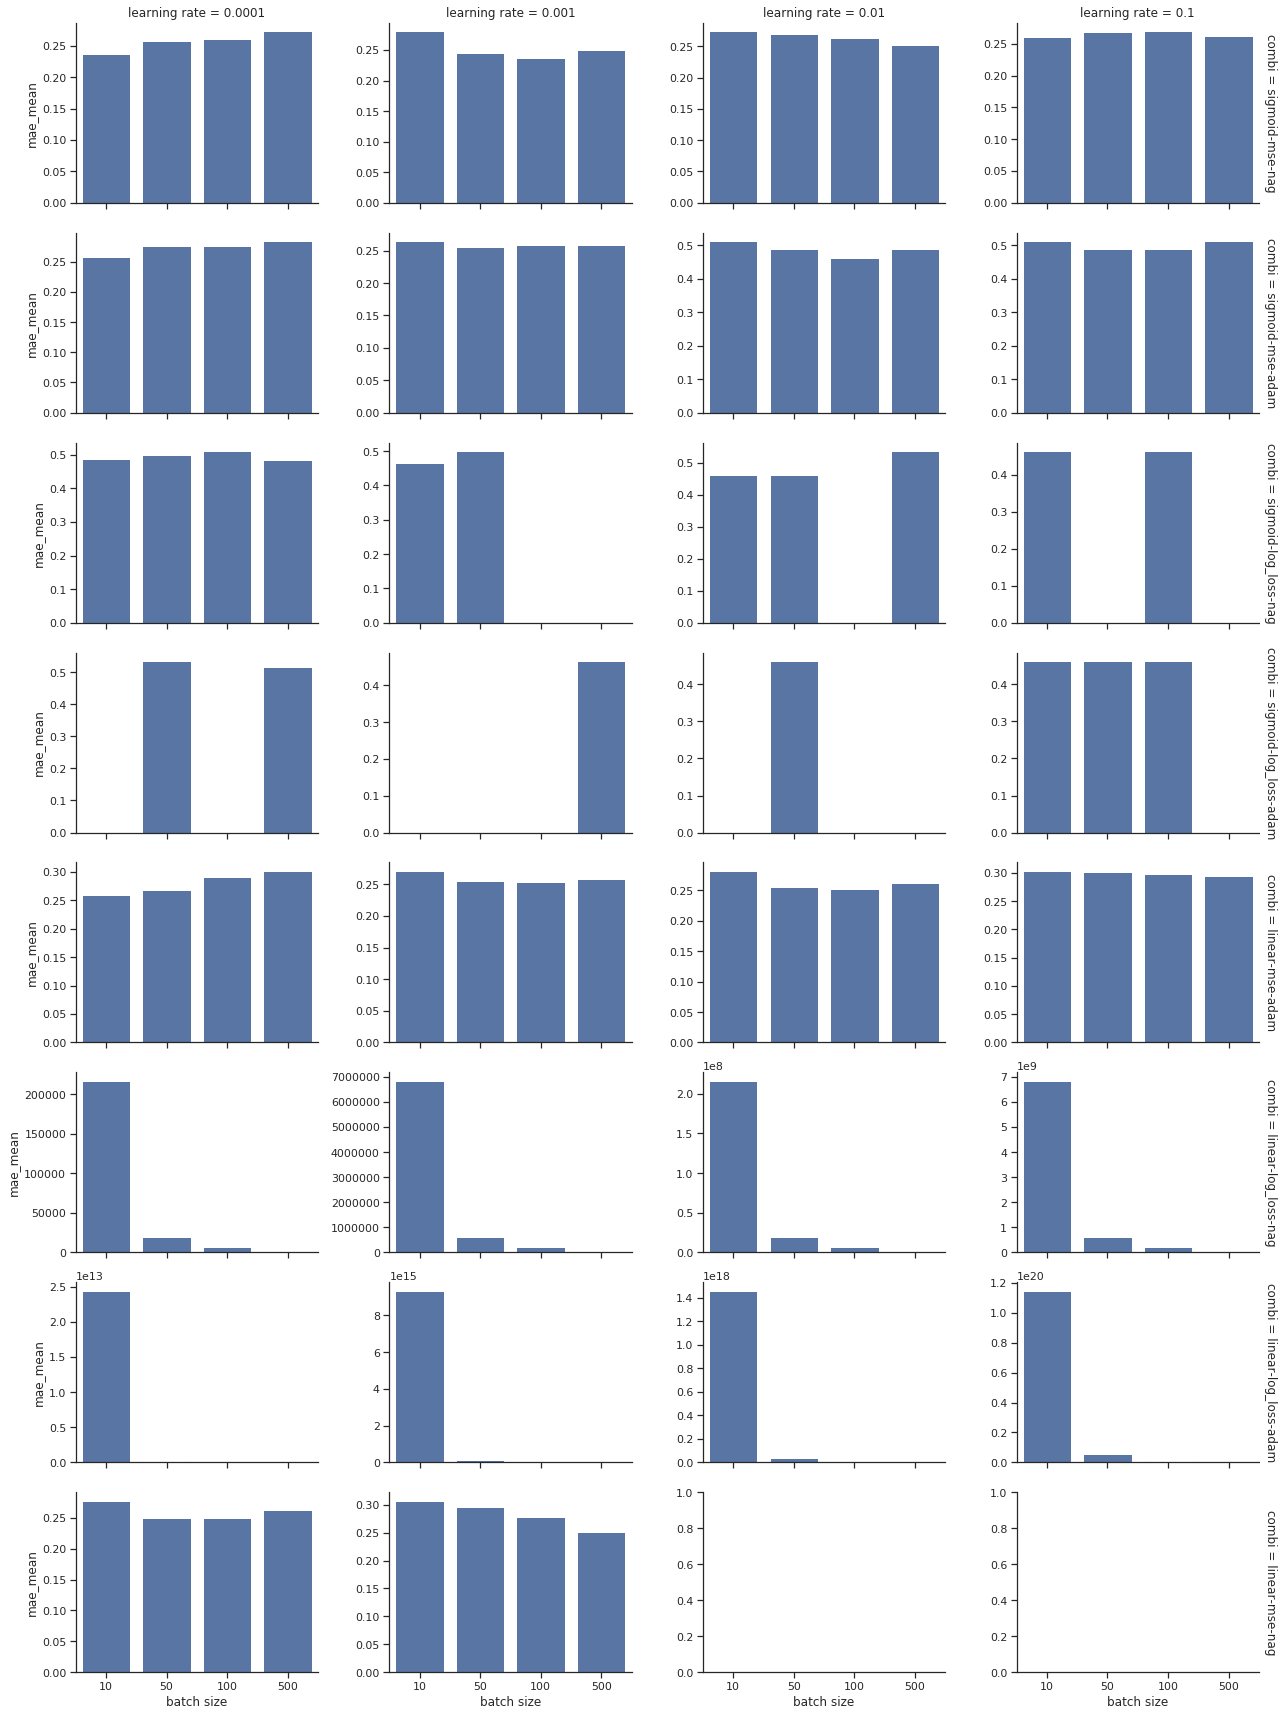

In [20]:
g = sns.FacetGrid(plt_data, col="learning rate", row = "combi", sharey=False, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "batch size", "mae_mean", order = [10, 50, 100, 500])
plt.show()

We see, that combining a linear activation with log loss leads to unreasonably high mean errors.  
Apart from that, averaging over all learning rates and batch sizes seems fair the other comibnations.

In [21]:
# group and check mean mae and loss
data_rm_na.groupby(["last activation", "loss_funct", "optimiser"])["mae_mean", "mae_std", "mae_min"].mean()

mae_mean       mae_std       mae_min
last activation loss_funct optimiser                                          
linear          log_loss   adam       7.672390e+18  5.559286e+17  7.040447e+18
                           nag        4.962897e+08  6.444116e+05  4.958493e+08
                mse        adam       2.755342e-01  7.218666e-03  2.689164e-01
                           nag        2.713644e-01  3.708342e-03  2.678981e-01
sigmoid         log_loss   adam       4.811802e-01  6.229844e-03  4.740441e-01
                           nag        4.855273e-01  1.923857e-02  4.712098e-01
                mse        adam       3.801231e-01  2.067254e-02  3.628871e-01
                           nag        2.602327e-01  4.474500e-03  2.560345e-01

After grouping and averaging, the high errors for linear+log_loss are clearly visible once more. In combination with a sigmoid activation, the log loss also does not perform as well as the mse-loss function. Apart from that, we generally do not observe a mae lower than 0.25, which still means that on average our probability estimates are 25% off - an unsatisfying result.